# **This notebook is a simple notebook that aims to make you understand one of the most basic task in computer vision: Image classification**

The dataset used here is CIFAR-10. You can download it at the following link: http://www.cs.utoronto.ca/~kriz/cifar.html 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes (airplane, automobile,	bird, cat, deer, dog,	frog, horse, ship truc), with 6000 images per class. The dataset is divided into five training batches (data_batch_1, data_batch_2,..., data_batch_5) and one test batch (test_batch), each with 10000 images.

First things first, let's explore the CIFAR-10 dataset. 

In [0]:
#Librairies importation
%matplotlib inline
from google.colab import drive
import pickle
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from random import randint
from keras import backend as K
from keras.models import Sequential
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,Dropout,BatchNormalization
from keras.models import Model
from keras import optimizers
from keras import regularizers
from keras.models import load_model
from keras.applications.resnet50 import ResNet50
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
#from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint, TensorBoard

drive.mount('/content/drive')#We create the link between google colab and google drive to access our data
sys.path.append('/content/drive/My Drive/Colab Notebooks/ImageClassification')
import visual_callbacks as ca

In [0]:
def unpickle(file):
  with open(file, 'rb') as myfile:
    dict = pickle.load(myfile, encoding='bytes')
    return dict

In [3]:
#Let's unpickle one of our train batch to see what's inside
myfile='/content/drive/My Drive/Colab Notebooks/ImageClassification/cifar-10-batches-py/data_batch_1'
dico= unpickle(myfile)
#Let's see what we have in our dictionnary
for key in dico:
  print(key,': ', dico[key])

b'batch_label' :  b'training batch 1 of 5'
b'labels' :  [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3

As we can see above, our dictionnary contains 4 keys. 

1.   batch_label which contains the name of the current batch on which we are working.
2.   labels which contains numbers, each number representing a class label.
3.   data which contains an array where the data are classified
4.   filenames which contains the name of each image that constitutes the dataset.

In [4]:
#Let's see what we have in the file batches.meta
myfile2='/content/drive/My Drive/Colab Notebooks/ImageClassification/cifar-10-batches-py/batches.meta'
dico2=unpickle(myfile2)
for key in dico2:
  print(key, ': ',dico2[key])

b'num_cases_per_batch' :  10000
b'label_names' :  [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
b'num_vis' :  3072


As we can see above, our dictionnary contains 3 keys.batch_label which contains 

1.   num_cases_per_batch which tells us how many examples we have per batch.
2.   labels_names which indicates the name of each label. The number 0 corresponds to the class airplaine, 1-->automobile, ...., 9-->truck
3.   num_vis tells=height*width*channel of an image (h=32,w=32,c=3)

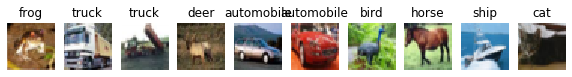

In [5]:
#Let's explore the key 'data' more and display some images
 data=dico[b'data']
 label=dico[b'labels']
 labelname=dico2[b'label_names']
 #print('The size of data is:', data.shape)
 #We reshape data and transpose it to have the right order for our data
data=np.reshape(data,(10000,3,32,32))
data=np.transpose(data,(0,2,3,1))
 #We take the some elements of data and display them
plt.figure(figsize=(10,10))
count=0
number=10
for i in range(number):
  plt.subplot(1,number,count+1)
  plt.imshow(data[count])
  plt.title(labelname[label[i]].decode("utf-8") )#If you check, you'll see that the elements in label are bytes type, to display them as a string, we use .decode('utf-8')
  plt.axis('off')
  count+=1
plt.show()

In [6]:
'''image={}
for i in range(len(label)):
  if(label[i] not in image):
    image[label[i]]=[]
    image[label[i]].append(i)
  elif (label[i] in image and len(image[label[i]])<10):
    image[label[i]].append(i)
j=0
plt.figure(figsize=(7,7))
for element in sorted(image):
  for i in range(len(image[element])):
    j+=1
    plt.subplot(10,10,j)
    plt.imshow(data[image[element]][i])
    plt.axis('off')'''#Just to show the images from every classes

"image={}\nfor i in range(len(label)):\n  if(label[i] not in image):\n    image[label[i]]=[]\n    image[label[i]].append(i)\n  elif (label[i] in image and len(image[label[i]])<10):\n    image[label[i]].append(i)\nj=0\nplt.figure(figsize=(7,7))\nfor element in sorted(image):\n  for i in range(len(image[element])):\n    j+=1\n    plt.subplot(10,10,j)\n    plt.imshow(data[image[element]][i])\n    plt.axis('off')"

# **DATASET PREPARATION**

Now that we know what we have in our files, let's prepare the data so they can be ready for the training.

In [0]:
#STEP 1: Let's gather data from the various train files we have
filepath='/content/drive/My Drive/Colab Notebooks/ImageClassification/cifar-10-batches-py'

def dataset_preparation(filename):
  
  '''This extract the data and labels from a file given as input and returns those information
  Input 
    #filename: type(str): is the absolute path of the file from which we want to extract the information
  Outputs
    #X:type(numpy array): contains the image data
    #Y:type(list): contains the labels associated to the images '''
  try:
    if(os.path.isfile(filename)):
      dic=unpickle(filename)
      X=dic[b'data']
      Y=dic[b'labels']

      X=np.reshape(X,(10000,3,32,32))
      X=np.transpose(X,(0,2,3,1))

      return X,Y

    else:
      print('Sorry but the file name you gave as an argument does not seem to exist')
  
  except:
    print('A problem occured')


In [8]:
#Let's start by the training set
for i in range(1,6):
  filename=os.path.join(filepath,'data_batch_'+str(i))
  if(i==1):
    Xtrain,Ytrain=dataset_preparation(filename)
  else:
    Xtrain=np.concatenate((Xtrain,dataset_preparation(filename)[0]))
    Ytrain=Ytrain+dataset_preparation(filename)[1]

#Now let's handle the test set
Xtest,Ytest=dataset_preparation(os.path.join(filepath,'test_batch'))

print(Xtrain.shape, len(Ytrain), Xtest.shape, len(Ytest))#Just to check that everything went without a hitch

(50000, 32, 32, 3) 50000 (10000, 32, 32, 3) 10000


In [0]:
#Let's preprocess the data: We normalize the data and binarize the labels 
Xtrain=Xtrain.astype('float32')/255.0
Xtest=Xtest.astype('float32')/255.0
Ytrain=to_categorical(Ytrain, num_classes=10, dtype='int32')
Ytest=to_categorical(Ytest, num_classes=10, dtype='int32')

#lb = LabelBinarizer() #This is an alternative to 'categorical'
#Ytrain = lb.fit_transform(Ytrain)
#Ytest = lb.fit_transform(Ytest) 

In [0]:
classes=list()
for element in labelname:
  classes.append(element.decode("utf-8"))

# **Let's build our Neural Network**

In [0]:
def mymodel():
  '''This method aims to create the Neural Network that will be used to classify the CIFAR-10 images.
  Output:
    #The built model '''

  model=Sequential()
  model.add(Conv2D(32,(3,3), activation='relu',name='Conv1',input_shape=(32,32,3),data_format='channels_first',padding="same",kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Conv2D(32,(3,3), activation='relu',name='Conv12',data_format='channels_first',padding="same",kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64,(3,3), activation='relu',name='Conv21',data_format='channels_first',padding="same",kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(3,3), activation='relu',name='Conv22',data_format='channels_first',padding="same",kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(128,(3,3), activation='relu',name='Conv31',data_format='channels_first',padding="same",kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(3,3), activation='relu',name='Conv32',data_format='channels_first',padding="same",kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))


  model.add(Dense(10,activation='softmax',name='Output_layer'))

  model.summary()

  return model

Let's train the model


In [0]:
bs=64
# create data generator
gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,horizontal_flip=True)
# prepare iterator
data_train =gen.flow(Xtrain, Ytrain, batch_size=bs)
#create the model
#model=mymodel()
model=load_model('/content/drive/My Drive/Colab Notebooks/ImageClassification/saved_model/saved_model.hdf5')
sgd = optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#We create 4 callbacks: one to display the curves, one to display the confusion matrix after each epoch, one for the visualisation in tensorboard and one to save the model
curves=ca.AccLossPlotter()
confusion=ca.ConfusionMatrixPlotter( Xtest, Ytest, classes, normalize=True)
visualize=TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=bs, update_freq='epoch')
best_model=ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/ImageClassification/saved_model/best_model.hdf5',save_best_only=True)
save_model=ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/ImageClassification/saved_model/saved_model.hdf5',save_best_only=False)
# We fit the model
model.fit_generator(data_train, epochs=200, verbose=1, callbacks=[curves,confusion,visualize,save_model,best_model],  validation_data=(Xtest, Ytest))

# **INFERENCE PHASE**

In this part, we will use our trained model to predict the class of some test images.

True label:  automobile 	 Predicted class:  automobile


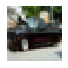

In [14]:
#We first load the model
model=load_model('/content/drive/My Drive/Colab Notebooks/ImageClassification/saved_model/saved_model.hdf5')
#Now, I choose a random number
k=randint(0,len(Xtest))
#We select the corresponding data in our test set
x=Xtest[k]
x=x.reshape((-1, x.shape[0], x.shape[1], x.shape[2]))
#We predict the class
pred=model.predict(x)
pred=np.argmax(pred, axis=1)
ground_truth=np.argmax(Ytest[k])
#We diqplay the predicted class, the ground truth label as well as the image
plt.figure(figsize=(1,1))
print('True label: ',classes[ground_truth], '\t Predicted class: ',classes[pred[0]] )
plt.imshow(Xtest[k])
plt.axis('off')
plt.show()